In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.06)&(summed_rain_each_period>0.0)]
    moderaterainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.15)&(summed_rain_each_period>0.06)]
    heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.15)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1
    summed_rain_each_period.loc[moderaterainfall_times.index] = 2
    summed_rain_each_period.loc[heavyrainfall_times.index] = 3

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values

    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,1,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)

In [6]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [7]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 3, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-01-01 00:00:00,2023-01-01,00:00,48.2,1008.5,80.8,0.0
2023-01-01 01:00:00,2023-01-01,01:00,48.5,1009.2,81.2,0.0
2023-01-01 02:00:00,2023-01-01,02:00,47.2,1009.8,89.0,0.0
2023-01-01 03:00:00,2023-01-01,03:00,47.3,1010.2,87.6,0.0
2023-01-01 04:00:00,2023-01-01,04:00,47.0,1011.0,87.9,1.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,13:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,14:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,15:00,52.4,1017.0,69.1,0.0


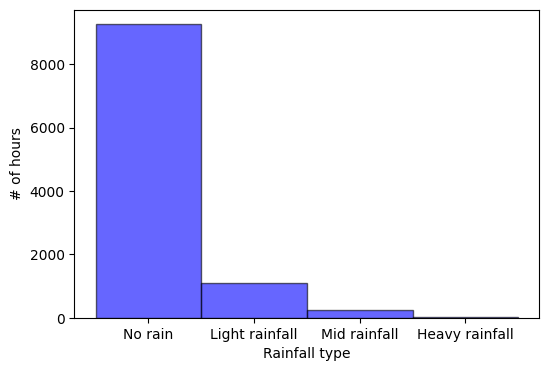

(array([9256, 1097,  256,   32]), array([0., 1., 2., 3., 4.]))

In [8]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [9]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = (np.abs(months - 7))
    processed_df['time_of_day'] = ((hours-8)%24) // 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [10]:
def create_oversampled_df(processed_df):
    num_zeros = processed_df[processed_df['class']==0].shape[0]

    zeros_samps = processed_df[processed_df['class']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 4):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        group_samps = under_group_samps.sample(n=num_zeros, replace=True, random_state=42)
        np.random.seed(42)
        noise = np.random.normal(0,1,num_zeros)
        group_samps['feature_1'] = group_samps['feature_1']+noise
        group_samps['feature_2'] = group_samps['feature_2']+noise
        group_samps['feature_3'] = group_samps['feature_3']+noise
        dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [11]:
raw_df_train_val, raw_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

In [12]:
under_sam_reltimes = get_processed_df_from_data(raw_under_df_train)
processed_df_train = create_oversampled_df(under_sam_reltimes)
processed_df_val = get_processed_df_from_data(raw_df_val)
processed_df_test = get_processed_df_from_data(raw_df_test)
processed_df_train

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
0,3,2,65.700000,62.000000,1014.700000,0.0
1,1,1,61.600000,76.200000,1012.300000,0.0
2,2,3,62.800000,72.000000,1016.800000,0.0
3,3,1,49.400000,81.000000,1010.300000,0.0
4,3,1,53.900000,46.900000,1023.100000,0.0
...,...,...,...,...,...,...
5303,2,3,45.802380,91.302380,1012.902380,3.0
1354,3,3,57.734759,78.034759,993.034759,3.0
3448,4,2,40.028830,77.728830,1015.528830,3.0
3448,4,2,43.735874,81.435874,1019.235874,3.0


In [13]:
processed_df_train.shape, processed_df_val.shape, processed_df_test.shape

((22192, 6), (2128, 6), (2129, 6))

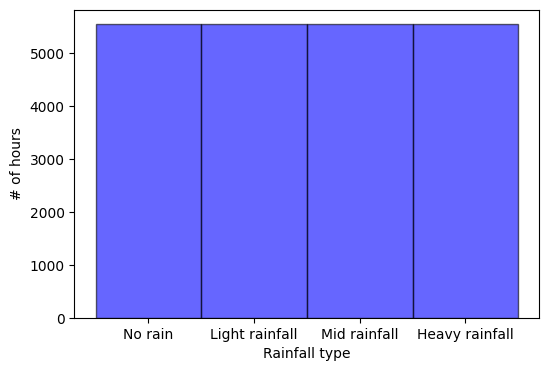

(array([5548, 5548, 5548, 5548]), array([0., 1., 2., 3., 4.]))

In [14]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

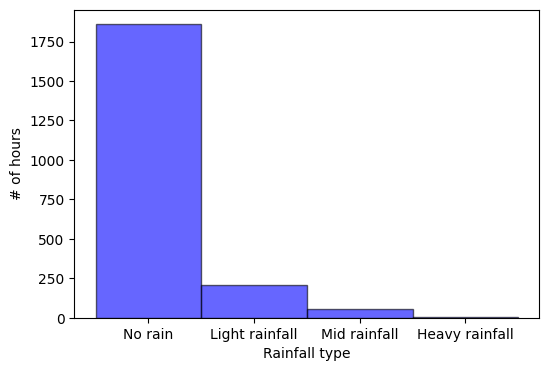

(array([1859,  205,   57,    7]), array([0., 1., 2., 3., 4.]))

In [15]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

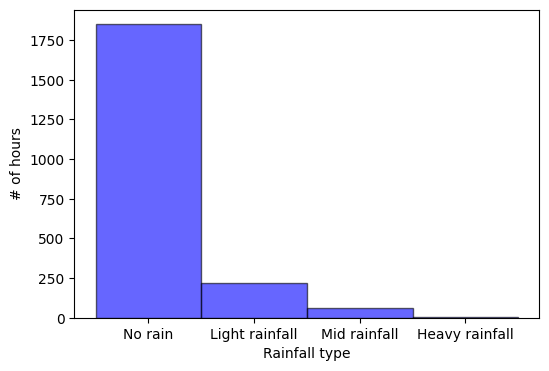

(array([1849,  218,   59,    3]), array([0., 1., 2., 3., 4.]))

In [16]:
rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [17]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(22192, 6)

In [18]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(2128, 6)

In [19]:
processed_data_test = processed_df_test.values.astype(float)
processed_data_test.shape

(2129, 6)

In [20]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_data_train = processed_data_train[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_train[0], y_data_train[0])

[   3.     2.    65.7   62.  1014.7] [0]


In [21]:
x_data_val = processed_data_val[:, :processed_data_train.shape[1]-1]
y_data_val = processed_data_val[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_val[0], y_data_val[0])

[   5.     0.    45.6   99.1 1012.4] [0]


In [22]:
x_data_test = processed_data_test[:, :processed_data_train.shape[1]-1]
y_data_test = processed_data_test[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_test[0], y_data_test[0])

[   5.     0.    39.2   77.4 1020.8] [0]


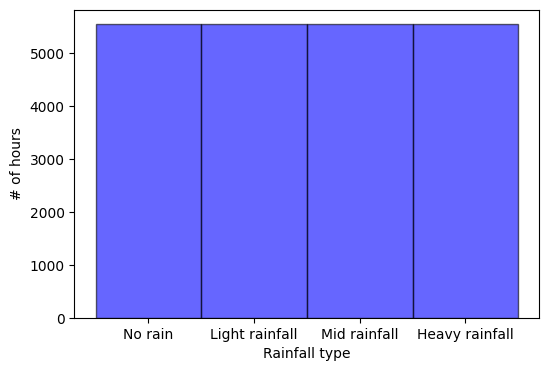

(array([5548, 5548, 5548, 5548]), array([0, 1, 2, 3, 4]))

In [23]:
rain_counts, classes = np.histogram(y_data_train, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

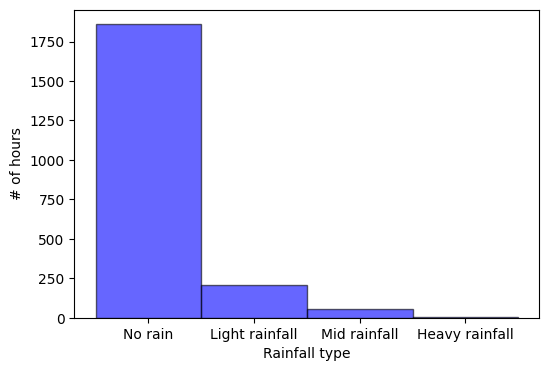

(array([1859,  205,   57,    7]), array([0, 1, 2, 3, 4]))

In [24]:
rain_counts, classes = np.histogram(y_data_val, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

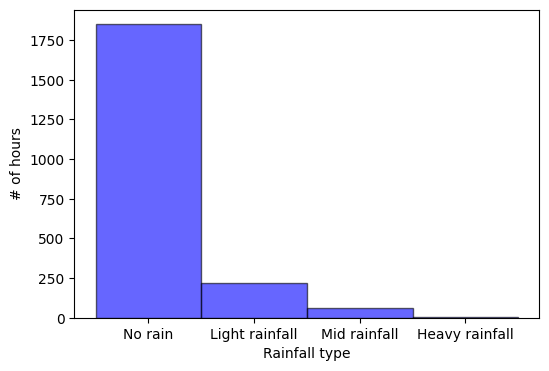

(array([1849,  218,   59,    3]), array([0, 1, 2, 3, 4]))

In [25]:
rain_counts, classes = np.histogram(y_data_test, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(5,)))

# Hidden layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-25 11:50:47.464389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 11:50:47.466398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,596
Trainable params: 2,596
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train_scaled.shape, y_data_train.shape

((22192, 5), (22192, 1))

In [28]:
X_val_scaled.shape, y_data_val.shape

((2128, 5), (2128, 1))

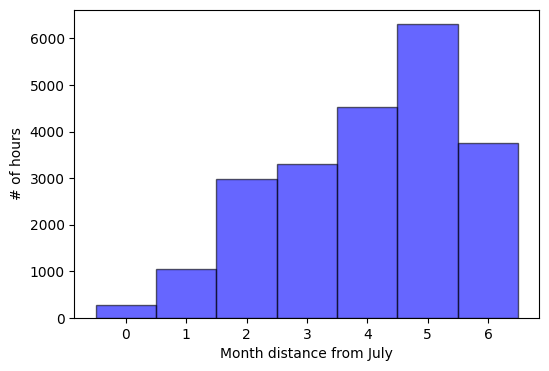

(array([ 269, 1043, 2988, 3313, 4532, 6302, 3745]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [29]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [30]:
X_train_scaled

array([[-0.67358493,  0.35023405,  2.1456313 , -1.56687882,  0.80160151],
       [-2.00290433, -0.51422975,  1.60712116, -0.53337625,  0.5087126 ],
       [-1.33824463,  1.21469786,  1.76473388, -0.83906011,  1.05787931],
       ...,
       [-0.00892522,  0.35023405, -1.22612117, -0.42210512,  0.9027495 ],
       [-0.00892522,  0.35023405, -0.73922352, -0.15229957,  1.35514612],
       [ 0.65573448,  1.21469786,  0.88065497,  1.07284528, -0.03203623]])

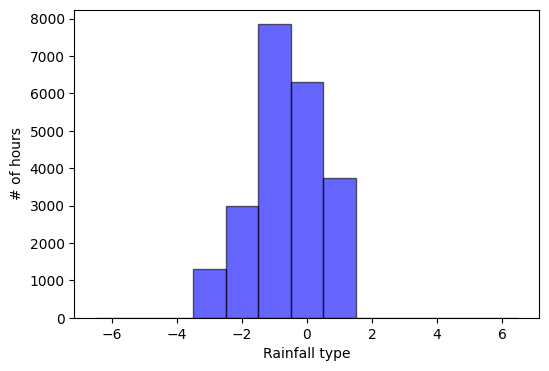

(array([   0,    0,    0, 1312, 2988, 7845, 6302, 3745,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [31]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [32]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-05-25 11:50:48.923295: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-25 11:50:49.195615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


694/694 [==============================] - ETA: 0s - loss: 1.2212 - accuracy: 0.4338

2024-05-25 11:51:00.420238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


694/694 [==============================] - 12s 12ms/step - loss: 1.2212 - accuracy: 0.4338 - val_loss: 0.9085 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 2/100
694/694 [==============================] - 6s 8ms/step - loss: 1.1030 - accuracy: 0.5063 - val_loss: 0.8843 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 3/100
694/694 [==============================] - 6s 8ms/step - loss: 1.0498 - accuracy: 0.5452 - val_loss: 0.9586 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 4/100
694/694 [==============================] - 5s 7ms/step - loss: 1.0049 - accuracy: 0.5686 - val_loss: 0.7670 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 5/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9737 - accuracy: 0.5830 - val_loss: 0.8476 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 6/100
694/694 [==============================] - 6s 9ms/step - loss: 0.9538 - accuracy: 0.5965 - val_loss: 0.9263 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 7/100
694/694 [==============================] - 6s 9ms/step - loss:

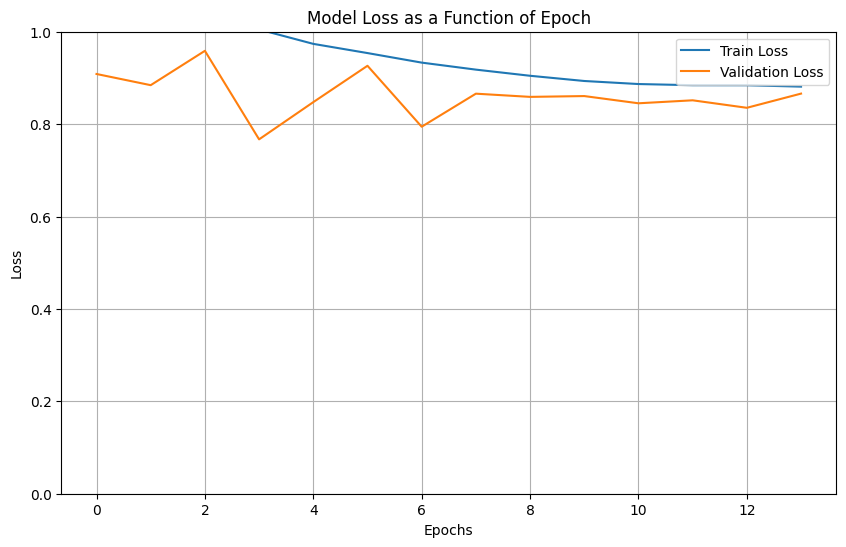

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

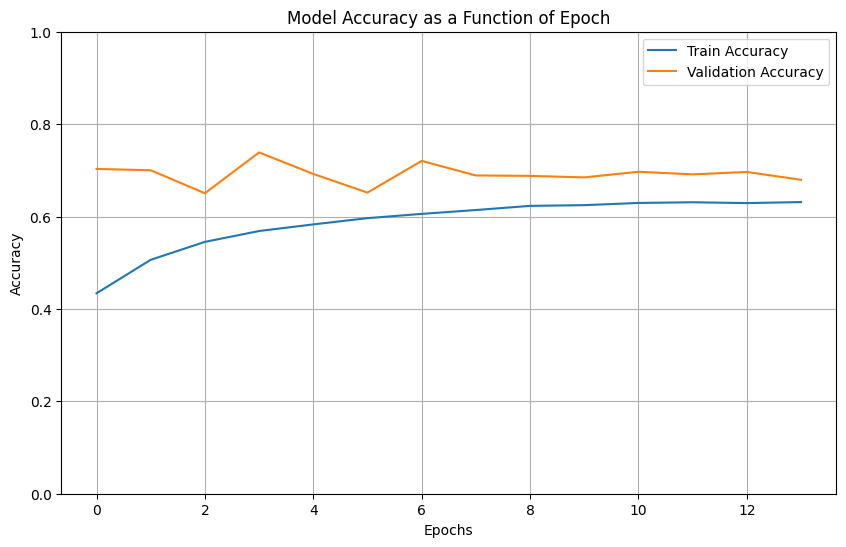

In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

In [36]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test.ravel().astype(float), verbose=2)

67/67 [==============================] - 0s 2ms/step


2024-05-25 11:52:16.503988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-05-25 11:52:16.807761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 - 0s - loss: 0.7889 - accuracy: 0.7163 - 475ms/epoch - 7ms/step


[0.7889147400856018, 0.7162987589836121]

Confusion Matrix:
[[1428  259   95   67]
 [  54   71   61   32]
 [   5   22   25    7]
 [   0    2    0    1]]


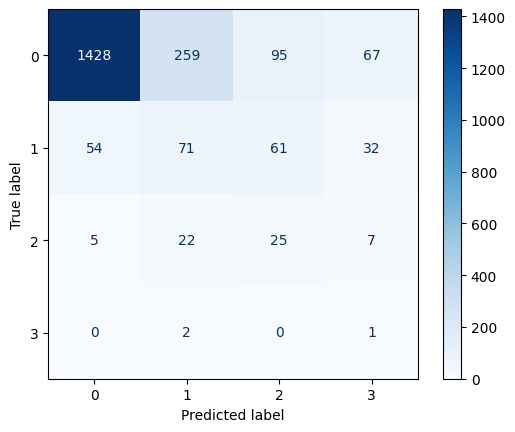

In [37]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[1428  259   95   67]
 [  54   71   61   32]
 [   5   22   25    7]
 [   0    2    0    1]]


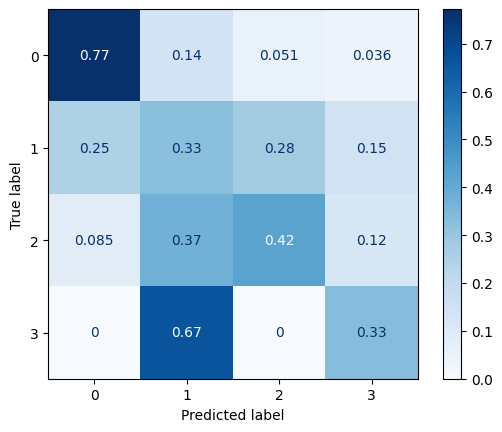

In [38]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(4, 1)), display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [39]:
f1_score(y_data_test.ravel(), np.argmax(predictions,axis=1), average=None)

array([0.85611511, 0.24825175, 0.20833333, 0.01818182])